In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra
from pyiga import assemble
from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import json
from os.path import exists
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


setting up constraints took 0.04084157943725586 seconds.
Basis setup took 0.0187833309173584 seconds


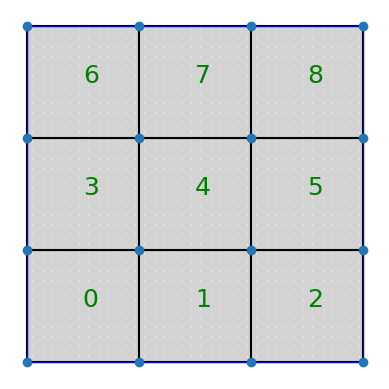

In [3]:
# define discretization space (the same in each patch)
deg = 1
N = 50
k = 1

geos = [
    geometry.unit_square(),
    geometry.unit_square().translate((1,0)),
    geometry.unit_square().translate((2,0)),
    geometry.unit_square().translate((0,1)),
    geometry.unit_square().translate((1,1)),
    geometry.unit_square().translate((2,1)),
    geometry.unit_square().translate((0,2)),
    geometry.unit_square().translate((1,2)),
    geometry.unit_square().translate((2,2)),
]

#kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),) if i%2==0 else 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),) for i in range(len(geos))]
#kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),), 2 * (bspline.make_knots(p, 0.0, 1.0, k*N),),2 * (bspline.make_knots(p, 0.0, 1.0, k*N),), 2 * (bspline.make_knots(p, 0.0, 1.0, N),)] # 15
kvs=9*[2*(bspline.make_knots(deg,0.0,1.0,N),)]
patches = [(kvs, g) for kvs, g in zip(kvs,geos)]

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)
MP = assemble.Multipatch(M, automatch=True)
MP.set_dirichlet_boundary({0:lambda x,y:0.})
MP.mesh.draw(patch_idx = 1, knots=1, bcolor={0:'blue',1:'red'}, nodes=1, axis='off')
axis('scaled');

### Define data and prepare Dirichlet boundary dofs

# source term f and Dirichlet boundary function g
f = lambda x, y: 1.
g = lambda x, y: 0. 

params = {'f' : f, 'g' : g}

In [4]:
I = ieti.IetiDP(MP, dir_data = {0:g}, elim=False)
I.assemble(f=lambda x,y: 1.)
I.construct_primal_constraints()
I.construct_primal_basis()

In [5]:
# PsiK=[]
# cpp = I.space.get_crosspoints() 
# G = {}
# s=0
# for p in cpp:
#     for l, g in cpp[p]:
#         if g not in G:
#             G[g]=s
#             s+=1
# for p in range(len(I.space.mesh.patches)):
    
#     a = I.Ak[p]
#     c = I.Ck[p]
#     AC = scipy.sparse.bmat(
#     [[a, c.T],
#      [c,  None   ]], format='csr')
#     RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
#     psi = scipy.sparse.linalg.spsolve(AC, RHS)
#     psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
#     if psi.ndim==1: psi=psi[:,None]
#     data = np.ones(psi.shape[1])
#     ii = np.arange(len(cpp[p]))
#     jj = np.array([G[g] for _,g in cpp[p]])
#     r=coo_matrix((data,(ii,jj)),(psi.shape[1],len(G)))
#     PsiK.append(psi@r)
#     #print(PsiK.shape)
    
# #print(scipy.vstack(PsiK))
#     #Psik.append(psi)
#     #self.Rk.append(r)

In [6]:
F,b= I.compute_F()

In [7]:
MsD = I.MsD()

In [8]:
# F_mat = F.dot(np.eye(F.shape[1]))

# print("Condition of Schur Complement: "+str(algebra.condest(F_mat)))
# print("Condition of preconditioned Schur Complement: "+str(algebra.condest(MsD@F_mat)))

In [15]:
### Solve the system with PCG
lam, it, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD, output=1, tol=1e-6)

pcg stopped after 3 iterations with relres 1.060068983187972e-07


In [96]:
patches = [(2*(bspline.make_knots(1,0.0,1.0,1),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.h_refine({0:0})
M.h_refine({1:1})
M.h_refine({1:0})
M.h_refine({2:0})
MP = assemble.Multipatch(M, automatch=True)
I = ieti.IetiDP(MP, dir_data = {0:g}, elim=False)

setting up constraints took 0.02475738525390625 seconds.
Basis setup took 0.014345645904541016 seconds


In [5]:
loc_c = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True)+MP.N_ofs[p] for p, kvs in enumerate(MP.mesh.kvs)])
i_loc_c = np.setdiff1d(loc_c, I.global_dir_idx)

B = MP.Basis[i_loc_c,:]
C_dofs = np.unique(B[B.getnnz(axis=1)==1].indices)
#return {p:[(l,g) for l] for p in range(MP.numpatches)}
Nodes = {c:MP.Basis[:,c].tocsc().indices for c in C_dofs}
#t_idx = np.where(B.getnnz(axis=1)>1)[0]
# A={}
# for row in t_idx:
#     tup = tuple(t_idx[row].indices)
#     if tup in A:
        
#     else:
#         A[tup] = 
#T_dofs = [tuple(row.indices) for row in t_idx]
#Nodes.update({t:MP.Basis[:,t]})
    #T_dofs = set([ for ])
    #T_dofs = B[]
    #g_dofs = np.unique(B.indices)

In [6]:
Nodes

{18: array([ 8, 15, 29, 36], dtype=int32),
 22: array([44, 51, 65, 72], dtype=int32),
 23: array([17, 24, 38, 45], dtype=int32),
 35: array([35, 42, 56, 63], dtype=int32)}

In [98]:
B.getnnz(axis=1)>1

array([ True, False,  True, False, False, False])

In [95]:
B

<6x29 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [85]:
MP.Basis[:,T_dofs[0]].sum(axis=1)

matrix([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [103]:
MP.Basis[:,18].tocsc().indices

array([ 8, 15, 29, 36], dtype=int32)

In [79]:
B.indices

array([18, 18, 23, 23, 18, 35, 18, 23, 35, 22, 23, 22, 35, 35, 22, 22], dtype=int32)

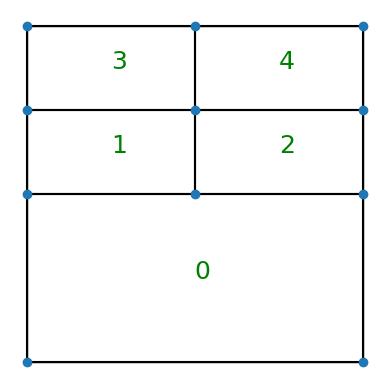

In [99]:
MP.mesh.draw(knots=1,nodes=1,patch_idx=1)
axis('off');

In [116]:
#kvs_ = MP.mesh.kvs
geos = MP.mesh.geos
kvs = MP.mesh.kvs
idx=[]
vals=[]
for key in MP.mesh.outer_boundaries:
    for p,b in MP.mesh.outer_boundaries[key]:
        idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p],geos[p],[(b//2,b%2)],lambda x,y : 1.)
        idx.append(idx_+MP.N_ofs[p])
        vals.append(vals_)
        
uidx, lookup = np.unique(idx, return_index=True)
#vals = np.concatenate(vals)
bcs=tuple((uidx,np.concatenate(vals)[lookup]))

cpp = MP.get_crosspoints()

/home/wolfman/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


ValueError: operands could not be broadcast together with shapes (10,) (6,) 

In [10]:
### Linear system assembly and restrictions

# assemble the lhs of the linear system
Ak = [assemble.assemble('inner(grad(u),grad(v)) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for kvs, g in zip(kvs,geos)]
#Ak = [assemble.assemble('inner(grad(grad(u)), grad(grad(v))) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for g in geos]
A = scipy.sparse.block_diag(Ak, format='csr')

#print("Rank ", np.linalg.matrix_rank(A.A), " vs. shape ", A.shape)


# Assemble the rhs of the linear system 
rhs = [assemble.assemble('f * v * dx', kvs, params, bfuns=[('v',1)], geo=g, f=lambda x,y: 1.).ravel() for kvs, g in zip(kvs,geos)]
# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
N = MP.Basis@MP.assemble_surface('g1 * inner(grad(v),n) * ds', arity=1, g1=g, boundary_idx=0)
rhs = np.hstack(rhs) + N

# Eliminate Dirichlet dofs
BCRestr = assemble.RestrictedLinearSystem(A, rhs, bcs)
free_dofs = BCRestr.R_free

# Eliminate the Dirichlet dofs from the interface dofs
nnz_per_col = MP.Constr.getnnz(axis=0)
intf_dofs = np.where(nnz_per_col > 0)[0]
intfs = np.setdiff1d(intf_dofs, bcs[0])

# Patchwise restrictions
"""
Akii = []
Akbb = []
Akbi = []
bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs)])
for p in range(len(MP.mesh.patches)):
    I = scipy.sparse.eye(Ak[p].shape[1], format='csr')
    mask = np.zeros(Ak[p].shape[1], dtype=bool)

    intindices = (intfs < MP.N_ofs[p+1]) & (intfs >= MP.N_ofs[p])
    intindices = intfs[intindices]-MP.N_ofs[p]
    
    mask[intindices] = True
    Rbb = I[mask]
    Akbb.append(Rbb.dot(Ak[p]).dot(Rbb.T)) 
    
    mask = np.ones(Ak[p].shape[1], dtype=bool)
    mask[bnd_dofs] = False
    Rii = I[mask]
    Akii.append(Rii.dot(Ak[p]).dot(Rii.T)) 
    
    Akbi.append(Rbb.dot(Ak[p]).dot(Rii.T))
""" 

# Compute the partial matrices 
Id = scipy.sparse.eye(A.shape[1], format='csr')
mask = np.zeros(A.shape[1], dtype=bool)
mask[list(intfs)] = True
Rbb = Id[mask]
mask = np.ones(A.shape[1], dtype=bool)

for p in range(len(patches)):
    bnd_dofs = np.concatenate([indices for indices in assemble.boundary_dofs(kvs[p])])
    mask[bnd_dofs+MP.N_ofs[p]] = False

Rii = Id[mask]

Abb = Rbb.dot(A).dot(Rbb.T)
Aii = Rii.dot(A).dot(Rii.T)
Abi = Rbb.dot(A).dot(Rii.T)
Aib = Abi.T
#print(Abi.shape)

# The matrices and vectors without the Dirichlet dofs
A = BCRestr.A
rhs = BCRestr.b

#print("Rank ", np.linalg.matrix_rank(A.A), " vs. shape ", A.shape)

assert A.shape[1] == rhs.shape[0], "Size of rhs is different to size of the matrix"

# Other method for assembly
#def bilinear():
#    vf = vform.VForm(2)
#   u, v = vf.basisfuns()
#    vf.add(vform.tr(vform.hess(u)) * vform.tr(vform.hess(v)) * vform.dx)
#    return vf

#a = bilinear()

In [11]:
### Construct the constraint matrix C that immediately eliminates the columns related to Dirichlet conditions
def construct_constraint_matrices():
    eliminate_constraints = np.array([], dtype=int)
    Ck = []
    loc_dirichlet = []
    for p in range(len(MP.mesh.patches)):
        bndindices = (bcs[0] < MP.N_ofs[p+1]) & (bcs[0] >= MP.N_ofs[p])
        to_eliminate = bcs[0][bndindices]-MP.N_ofs[p]
        
        loc, _ = cpp[p][0]
        
        nnz_per_row = MP.Constr[:,loc+MP.N_ofs[p]].getnnz(axis=1)
        result = np.where(nnz_per_row > 0)[0]
        eliminate_constraints = np.union1d(eliminate_constraints, result)
        
        ck = MP.Constr[result,MP.N_ofs[p]:MP.N_ofs[p+1]]
        ck = np.delete(ck.A, 
                       to_eliminate, 
                       axis=1)
                
        q,r = np.linalg.qr(ck.T)
        ck = scipy.sparse.csr_matrix(ck[np.abs(np.diag(r))>=1e-10])
        
        #if p == 3:
        #    print("Ck", result)
        
        Ck.append(ck)
        loc_dirichlet.append(to_eliminate)

    return Ck, scipy.sparse.block_diag(Ck), eliminate_constraints, loc_dirichlet

In [12]:
### Construct the constraint matrix C that immediately eliminates the columns related to Dirichlet conditions
def construct_constraint_matrices2():
    eliminate_constraints = np.array([], dtype=int)
    Ck = []
    loc_dirichlet = []
    for p in range(len(MP.mesh.patches)):
        bndindices = (bcs[0] < MP.N_ofs[p+1]) & (bcs[0] >= MP.N_ofs[p])
        to_eliminate = bcs[0][bndindices]-MP.N_ofs[p]
        free = np.setdiff1d(np.arange(MP.N[p]),to_eliminate)
        primal = assemble.boundary_dofs(kvs, m=0, ravel=1)
        primal_free = np.setdiff1d(primal, to_eliminate)
        
        #loc, _ = cpp[p][0]
        
        data = np.ones(len(primal_free))
        rows = np.arange(len(primal_free))
        cols = primal_free
        ck = coo_matrix((data, (rows, cols)),(len(primal_free),MP.N[p])).tocsc()
        ck = ck[:,free]
        Ck.append(ck)

    return Ck, scipy.sparse.block_diag(Ck), eliminate_constraints, loc_dirichlet

In [13]:
Ck, C, eliminate_rows, loc_dirichlet = construct_constraint_matrices()

In [14]:
def construct_primal_basis(Ak, Ck):
    Psi = []
    for p in range(len(patches)):
        a = Ak[p*Ck[p].shape[1]:(p+1)*Ck[p].shape[1], p*Ck[p].shape[1]:(p+1)*Ck[p].shape[1]]
        c = Ck[p]
        AC = scipy.sparse.bmat(
        [[a, c.T],
         [c,  None   ]], format='csr')
        RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.identity(c.shape[0])])
        psi = scipy.sparse.linalg.spsolve(AC, RHS)
        psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
        if len(psi.shape)==1: psi=psi[None]
        
        Psi.append(psi)
        
    return Psi

In [15]:
Psik=construct_primal_basis(A, Ck)

PSI = scipy.sparse.bmat([[Psik[0], None,    None,    None   ],
                         [None,    Psik[1], None,    None   ],
                         [None,    None,    Psik[2], None   ],
                         [None,    None,    None,    Psik[3]]], format='csr')

In [16]:
# Prepare the jump matrix 
# I.e., eliminate the rows related to corner constraints
B = MP.Constr
B = scipy.sparse.csr_matrix(np.delete(B.A, eliminate_rows, axis=0))
B = B@free_dofs.T

In [17]:
# Get all the matrices
PTAP = PSI@A@PSI.T
PTBT = PSI@B.T
BP   = B@PSI.T

In [18]:
### Set up the linear system
#A_ieti = scipy.sparse.bmat(
#    [[A,    C.T,  None, B.T  ],
#     [C,    None, None, None ],
#     [None, None, PTAP, PTBT ],
#     [B,    None, BP,   None ]], format='csr')

BL = scipy.sparse.bmat([[B,    np.zeros((B.shape[0],C.shape[0])), BP]], format='csr')
BR = scipy.sparse.bmat([[B.T],    
                        [np.zeros((C.shape[0],B.shape[0]))], 
                        [PTBT]], format='csr')
A0 = scipy.sparse.bmat(
    [[A,    C.T,  None],
     [C,    None, None],
     [None, None, PTAP]], format='csr')

print("Rank ", np.linalg.matrix_rank(PTAP.A), " vs. shape ", PTAP.shape)

b = np.hstack((rhs, np.zeros(C.shape[0],), PSI.dot(rhs), np.zeros(B.shape[0],)))

BR = scipy.sparse.linalg.aslinearoperator(BR)
BL = scipy.sparse.linalg.aslinearoperator(BL)
A0inv = solvers.make_solver(A0.A, spd=False)

F = BL@A0inv.dot(BR)

TR = np.hstack((rhs, np.zeros((C.shape[0],)), PSI.dot(rhs)))
b = BL@(A0inv.dot(TR))

"""
A0inv = scipy.sparse.linalg.spsolve(A0, BR.A)
F = BL@A0inv

A0inv = scipy.sparse.linalg.spsolve(A0, TR)
b = BL@A0inv
"""

Rank  4  vs. shape  (4, 4)


'\nA0inv = scipy.sparse.linalg.spsolve(A0, BR.A)\nF = BL@A0inv\n\nA0inv = scipy.sparse.linalg.spsolve(A0, TR)\nb = BL@A0inv\n'

In [19]:
### Dirichlet preconditioner MsD
B_gamma = MP.Constr
B_gamma = scipy.sparse.csr_matrix(np.delete(B_gamma.A, eliminate_rows, axis=0))
B_gamma = B_gamma@Rbb.T

#print(np.linalg.matrix_rank(Rbb.A, 1e-8))
#print(B_gamma.shape)

#Aib = scipy.sparse.linalg.aslinearoperator(Aib)
AiiinvB = scipy.sparse.linalg.spsolve(Aii, Aib.A)
S = Abb - Abi@AiiinvB
D = np.abs(B_gamma).sum(axis=0)
D = [1/(1+D[0,v]) for v in range(D.shape[1])]
D = scipy.sparse.diags(D, format='csr')

BgD = B_gamma@D
MsD = BgD@S@BgD.T    

In [76]:
scipy.sparse.csr_matrix(np.delete(MP.Constr.A, eliminate_rows, axis=0))

<8x36 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [75]:
I.B

<8x36 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [61]:
B_gamma

<8x12 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [52]:
MsD.A

array([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375,  0.     ,  0.     , -0.09375],
       [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375,  0.     ,  0.     ,  0.09375],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
       [ 0.     , -0.09375,  0.09375,  0.     ,  0.     ,  0.     ,  0.     ,  0.64583]])

In [30]:
I.eliminate_constraints

array([0, 2, 6, 8])

In [26]:
MsD

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375,  0.     ,  0.     , -0.09375],
        [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375,  0.     ,  0.     ,  0.09375],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     , -0.09375,  0.09375,  0.     ,  0.     ,  0.     ,  0.     ,  0.64583]])

In [28]:
I.MsD()

matrix([[ 0.64583,  0.     ,  0.     ,  0.     ,  0.09375,  0.     , -0.09375, -0.05208],
        [ 0.     ,  0.22569, -0.08681,  0.     , -0.05208,  0.     ,  0.03472, -0.06944],
        [ 0.     , -0.08681,  0.64583,  0.     , -0.09375,  0.     ,  0.09375,  0.03472],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.09375, -0.05208, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [-0.09375,  0.03472,  0.09375,  0.     ,  0.     ,  0.     ,  0.64583, -0.08681],
        [-0.05208, -0.06944,  0.03472,  0.     ,  0.     ,  0.     , -0.08681,  0.22569]])

In [44]:
B=MP.Constr

In [48]:
scipy.sparse.csr_matrix(np.delete(B.A, eliminate_rows, axis=0))

<8x36 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [49]:
B_gamma=B[np.setdiff1d(np.arange(B.shape[0]),eliminate_rows),:]

In [42]:
B_gamma@Rbb.T

<8x12 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [43]:
I.B_gamma

<5x12 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [32]:
eliminate_rows

array([ 2,  3,  6, 11])

In [83]:
### Solve the system with PCG
u, it, r = solvers.pcg(F, b, x0=None, maxiter=200, P=MsD.A, output=1, tol=1e-10)

pcg stopped after 4 iterations with relres 8.5775770503511e-11


In [21]:
F

<8x8 _ProductLinearOperator with dtype=float64>

In [66]:
it

3

In [22]:
MsD

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375,  0.     ,  0.     , -0.09375],
        [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375,  0.     ,  0.     ,  0.09375],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     , -0.09375,  0.09375,  0.     ,  0.     ,  0.     ,  0.     ,  0.64583]])

In [26]:
MsD_

matrix([[ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.64583,  0.     ,  0.     ,  0.09375],
        [ 0.     ,  0.     ,  0.64583,  0.     , -0.09375],
        [ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.09375, -0.09375,  0.     ,  0.64583]])